# Galassify

## Aplicación de Deep autoencoder para clusterización con dataset v3

Aunque posiblemente no sea el tipo de autoencoder que finalmente dé mayor accuracy, usamos de momento este modelo para avnzar en el proceso de clustering y crear un PMV lo antes posible.

En esta versión probamos con el dataset v3.

### Importación de librerías y carga de datos

In [220]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial import distance

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture as GMM

from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from keras.layers import Dropout, UpSampling2D, Conv1D, MaxPooling1D, UpSampling1D, Reshape, Cropping1D
from keras.layers import LSTM, RepeatVector, TimeDistributed
from keras.models import Model, Sequential
from keras.optimizers import Adam

%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', None)

In [221]:
data = pd.read_csv("./data/datasetV3.csv")
data.head()

,Plate,MJD,FIBER,Z,3824.0900218139773,3824.9718485269673,3825.851778274137,3826.731910447989,3827.614346374663,3828.4948840249895,3829.377726489477,3830.258669803082,3831.1419189926733,3832.0232681564457,3832.9048200734346,3833.788679459434,3834.670637506974,3835.554904086575,3836.437268451768,3837.3219424125623,3838.2047132826,3839.087687232917,3839.972972374428,3840.8563531104246,3841.7420461023817,3842.6258338114644,3843.511934841763,3844.396129711424,3845.280527988955,3846.1672411858654,3847.0520469052644,3847.939168610524,3848.8243819594973,3849.711912361307,3850.5975335276503,3851.483358429978,3852.37150198589,3853.257734987331,3854.1462877105573,3855.032928999122,3855.921891078168,3856.808940841952,3857.696194670371,3858.5857708925982,3859.473433478434,3860.3634195280047,3861.2514910595733,3862.141887125296,3863.030367790998,3863.919052850509,...,7320.288075153633,7321.97209780537,7323.66052839952,7325.345326879696,7327.0345353330185,7328.720109999056,7330.406072429329,7332.096447879399,7333.783187031765,7335.4743412370035,7337.161857469297,7338.8537907884765,7340.542084458699,7342.23076651866,7343.923868717072,7345.613328752057,7347.30721096185,7348.9974493302725,7350.692111910794,7352.383128971232,7354.074535047924,7355.770368393199,7357.462553699866,7359.159168314761,7360.8521332103965,7362.54952945484,7364.243274298602,7365.937408786139,7367.635977683898,7369.330892658391,7371.030244086034,7372.7259399070535,7374.4260742250935,7376.1225512523715,7377.8194185519615,7379.520727414929,7381.21837646048,7382.920469115634,7384.618900267294,7386.321777075727,7388.0209906938135,7389.720595213761,7391.424648461781,7393.125035988724,7394.829874293267,7396.5310451879395,7398.236668910681,7399.938623533977,7401.645033036759,7403.347771749743
0,523,52026,1,0.098682,1.135887,1.285232,0.825618,0.796722,0.817228,1.173118,1.097528,1.123260,1.216317,0.898871,0.656037,0.749630,0.829749,0.944026,0.688574,0.466537,1.002247,0.942571,0.807821,0.791703,0.766994,0.771141,1.053390,1.153064,1.005657,1.185850,1.060990,0.854074,0.678699,1.069651,0.894632,0.909577,0.959175,1.145742,1.012092,0.949373,1.258397,1.391541,1.238580,0.867599,0.945935,1.140513,0.921065,1.006719,0.891078,0.857002,...,1.070024,1.023151,1.061523,0.998105,0.989414,1.057423,1.150952,0.853410,1.348908,0.903176,0.961421,0.923473,0.901917,1.130446,1.030400,0.988021,1.069310,1.053208,1.046263,0.751132,0.982140,0.945225,0.930836,0.942840,0.958298,0.983793,0.998591,1.090840,1.014073,0.971881,1.030205,0.970596,1.025671,1.029004,1.113032,1.036568,0.959923,1.190478,1.226568,0.867987,0.932905,1.101022,0.857708,0.981225,1.057981,1.037990,1.126648,0.964613,1.143998,1.140777
1,523,52026,3,0.080600,0.671902,0.796325,0.669739,0.450846,0.205560,0.189083,0.363803,0.342009,0.312420,0.493719,0.583748,0.380693,0.159400,0.172996,0.148678,0.194632,0.399182,0.316204,0.113165,0.293415,0.524688,0.588610,0.606728,0.809279,1.051963,0.708907,0.307187,0.356962,0.572270,0.660287,0.411074,0.366896,0.554306,0.517045,0.383871,0.443580,0.513564,0.549834,0.617335,0.487898,0.364145,0.287178,0.314815,0.472669,0.373830,0.274626,...,1.299648,1.379560,1.339349,1.138453,1.166165,1.285420,1.213864,1.179763,1.176282,1.322921,1.326862,1.241125,1.244351,1.202471,1.257434,1.338722,1.337893,1.297162,1.207913,1.204164,1.233375,1.279788,1.173823,1.151892,1.208212,1.226859,1.284779,1.175297,1.223421,1.327009,1.372538,1.044056,1.084195,1.356617,1.280557,1.312559,1.297548,1.240537,1.348452,1.391131,1.287156,1.326092,1.298668,1.217913,1.191651,1.276162,1.340529,1.158287,1.187242,1.326882
2,523,52026,7,0.020568,1.333502,1.298719,1.114856,0.836212,0.943531,1.189700,0.924480,0.959885,1.277306,1.313994,1.260434,0.753867,0.890283,1.426697,1.065083,1.115711,1.131686,0.802055,0.922050,0.924328,0.703161,0.845462,1.336946,1.121475,0.674417,0.797437,1.089679,1.133756,1.083714,1.037537,0.867065,1.217732,1.502325,1.412486,1.085267,0.883105,1.108336,1.200063,1.122489,1.046208,1.193889,1.402158,1.452806,1.615764,1.618204,1.263288,...,0.6273

In [238]:
frecuencias = data.columns[4:]
data = data[frecuencias].copy()
data.head()

,3827.614346374663,3828.4948840249895,3829.377726489477,3830.258669803082,3831.1419189926733,3832.0232681564457,3832.9048200734346,3833.788679459434,3834.670637506974,3835.554904086575,3836.437268451768,3837.3219424125623,3838.2047132826,3839.087687232917,3839.972972374428,3840.8563531104246,3841.7420461023817,3842.6258338114644,3843.511934841763,3844.396129711424,3845.280527988955,3846.1672411858654,3847.0520469052644,3847.939168610524,3848.8243819594973,3849.711912361307,3850.5975335276503,3851.483358429978,3852.37150198589,3853.257734987331,3854.1462877105573,3855.032928999122,3855.921891078168,3856.808940841952,3857.696194670371,3858.5857708925982,3859.473433478434,3860.3634195280047,3861.2514910595733,3862.141887125296,3863.030367790998,3863.919052850509,3864.810064050088,3865.6991585263863,3866.5905802144025,3867.480084296104,3868.371916661669,3869.2618305374795,3870.151949136807,3871.044397628503,...,7320.288075153633,7321.97209780537,7323.66052839952,7325.345326879696,7327.0345353330185,7328.720109999056,7330.406072429329,7332.096447879399,7333.783187031765,7335.4743412370035,7337.161857469297,7338.8537907884765,7340.542084458699,7342.23076651866,7343.923868717072,7345.613328752057,7347.30721096185,7348.9974493302725,7350.692111910794,7352.383128971232,7354.074535047924,7355.770368393199,7357.462553699866,7359.159168314761,7360.8521332103965,7362.54952945484,7364.243274298602,7365.937408786139,7367.635977683898,7369.330892658391,7371.030244086034,7372.7259399070535,7374.4260742250935,7376.1225512523715,7377.8194185519615,7379.520727414929,7381.21837646048,7382.920469115634,7384.618900267294,7386.321777075727,7388.0209906938135,7389.720595213761,7391.424648461781,7393.125035988724,7394.829874293267,7396.5310451879395,7398.236668910681,7399.938623533977,7401.645033036759,7403.347771749743
0,0.817228,1.173118,1.097528,1.123260,1.216317,0.898871,0.656037,0.749630,0.829749,0.944026,0.688574,0.466537,1.002247,0.942571,0.807821,0.791703,0.766994,0.771141,1.053390,1.153064,1.005657,1.185850,1.060990,0.854074,0.678699,1.069651,0.894632,0.909577,0.959175,1.145742,1.012092,0.949373,1.258397,1.391541,1.238580,0.867599,0.945935,1.140513,0.921065,1.006719,0.891078,0.857002,0.738553,1.088869,1.396223,1.164779,1.101951,1.175489,1.466010,1.202211,...,1.070024,1.023151,1.061523,0.998105,0.989414,1.057423,1.150952,0.853410,1.348908,0.903176,0.961421,0.923473,0.901917,1.130446,1.030400,0.988021,1.069310,1.053208,1.046263,0.751132,0.982140,0.945225,0.930836,0.942840,0.958298,0.983793,0.998591,1.090840,1.014073,0.971881,1.030205,0.970596,1.025671,1.029004,1.113032,1.036568,0.959923,1.190478,1.226568,0.867987,0.932905,1.101022,0.857708,0.981225,1.057981,1.037990,1.126648,0.964613,1.143998,1.140777
1,0.205560,0.189083,0.363803,0.342009,0.312420,0.493719,0.583748,0.380693,0.159400,0.172996,0.148678,0.194632,0.399182,0.316204,0.113165,0.293415,0.524688,0.588610,0.606728,0.809279,1.051963,0.708907,0.307187,0.356962,0.572270,0.660287,0.411074,0.366896,0.554306,0.517045,0.383871,0.443580,0.513564,0.549834,0.617335,0.487898,0.364145,0.287178,0.314815,0.472669,0.373830,0.274626,0.460095,0.630313,0.505716,0.409140,0.550172,0.462173,0.402302,0.598662,...,1.299648,1.379560,1.339349,1.138453,1.166165,1.285420,1.213864,1.179763,1.176282,1.322921,1.326862,1.241125,1.244351,1.202471,1.257434,1.338722,1.337893,1.297162,1.207913,1.204164,1.233375,1.279788,1.173823,1.151892,1.208212,1.226859,1.284779,1.175297,1.223421,1.327009,1.372538,1.044056,1.084195,1.356617,1.280557,1.312559,1.297548,1.240537,1.348452,1.391131,1.287156,1.326092,1.298668,1.217913,1.191651,1.276162,1.340529,1.158287,1.187242,1.326882
2,0.943531,1.189700,0.924480,0.959885,1.277306,1.313994,1.260434,0.753867,0.890283,1.426697,1.065083,1.115711,1.131686,0.802055,0.922050,0.924328,0.703161,0.845462,1.336946,1.121475,0.674417,0.797437,1.089679,1.133756,1.083714,1.037537,0.867065,1.217732,1.502325,1.412486,1.085267,0.883105,1.108336,1.200063,1.122489,1.046208,1.193889,1.402158,1.452806,1.615764,

In [524]:
data.to_csv("./data/datasetV3_2.csv", index=False)

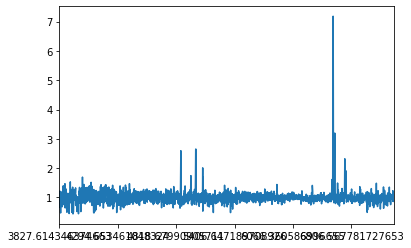

In [239]:
data.iloc[0].plot()

In [399]:
scaler = MinMaxScaler()
espectros = scaler.fit_transform(data)
espectros

array([[0.59761723, 0.25018394, 0.51049647, ..., 0.10546088, 0.1563924 ,
        0.18211367],
       [0.26610071, 0.04972391, 0.22800927, ..., 0.13597971, 0.16418526,
        0.22289295],
       [0.66607207, 0.25356197, 0.44387224, ..., 0.05413759, 0.07137378,
        0.06794521],
       ...,
       [0.27348114, 0.13967016, 0.31030956, ..., 0.15740293, 0.16009562,
        0.16184073],
       [0.37869509, 0.11643174, 0.24321518, ..., 0.16724966, 0.19634484,
        0.20655176],
       [0.57137355, 0.32873176, 0.66884972, ..., 0.06692084, 0.07786766,
        0.05981701]])

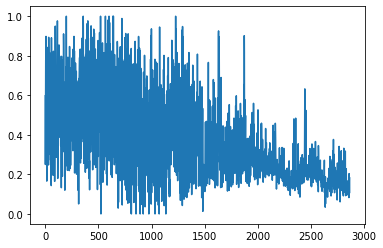

In [513]:
plt.plot(espectros[0]);

In [403]:
espectros.shape

(479, 2866)

Para luego entrenar los modelos y tener un set de test para las medidas de accuracy, dividimos el dataset en train y test (nos vale un 15% para el test). Recordemos que estamos usando un aprendizaje no supervisado y no tenemos etiquetas.

In [404]:
espectros_train, espectros_test, _, _ = train_test_split(espectros, espectros, test_size=0.15, random_state=21)

In [405]:
dim_latente = 50

In [406]:
dim_input = len(espectros_train[0])
dim_input

2866

In [211]:
# Función para mostrar la gráfica de evolución de loss y val loss en cada epoch durante el entrenamiento 
def grafica_loss(modelo, n_epochs):
    loss = modelo.history.history['loss']
    val_loss = modelo.history.history['val_loss']
    epochs = range(n_epochs)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Test loss')
    plt.title('Training and test loss')
    plt.legend()

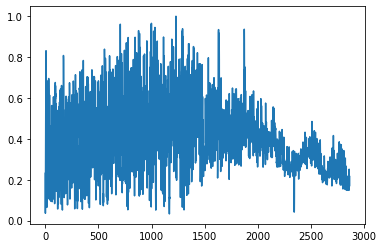

In [407]:
plt.plot(espectros_train[100]);

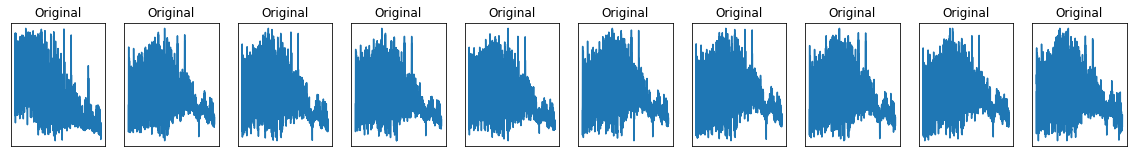

In [408]:
n = 10 
shift = 0
plt.figure(figsize=(20, 5))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.plot(espectros_train[i+shift])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("Original")

### Autoencoder deep

Usamos aquí una ligera variante del autoencoder visto en el notebook 1.

En cuanto a la función de activación, se ha probado con "selu", dado que parecía lo más recomendado según algún paper, pero los resultados son peores, por lo que volvemos a "relu".

In [514]:
input = Input(shape=((data.shape[1], )))
encoded = Dense(1500, activation='selu')(input)
encoded = Dense(500, activation='selu')(encoded)
encoded = Dense(50, activation='selu')(encoded)
decoded = Dense(500, activation='selu')(encoded)
decoded = Dense(1500, activation='selu')(decoded)
decoded = Dense(data.shape[1], activation='sigmoid')(decoded)

# Modelo para obtener el autoencoder completo
autoencoder_deep = Model(input, decoded)
autoencoder_deep.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        (None, 2866)              0         
_________________________________________________________________
dense_221 (Dense)            (None, 1500)              4300500   
_________________________________________________________________
dense_222 (Dense)            (None, 500)               750500    
_________________________________________________________________
dense_223 (Dense)            (None, 50)                25050     
_________________________________________________________________
dense_224 (Dense)            (None, 500)               25500     
_________________________________________________________________
dense_225 (Dense)            (None, 1500)              751500    
_________________________________________________________________
dense_226 (Dense)            (None, 2866)              4301866   
Total para

In [515]:
# Modelo para obtener el codificador y, por tanto, la imagen latente de cada espectro
encoder = Model(input, encoded)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        (None, 2866)              0         
_________________________________________________________________
dense_221 (Dense)            (None, 1500)              4300500   
_________________________________________________________________
dense_222 (Dense)            (None, 500)               750500    
_________________________________________________________________
dense_223 (Dense)            (None, 50)                25050     
Total params: 5,076,050
Trainable params: 5,076,050
Non-trainable params: 0
_________________________________________________________________


In [516]:
autoencoder_deep.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=["accuracy"])

* Usamos "adadelta" como optimizador por ser el más recomendado en los papers de sistemas como DEC, DCEC o DEPICT.
* "binary_crossentropy" es una función de error que contiene la diferencia entre la imagen de salida y la de entrada. Disminuyendo este error, obtendremos mejores copias de la entrada a la salida y, por tanto, un especio latente más representativo de la entrada.
* Usamos como métrica "accuracy" solo porque esto nos permitirá usar el comando "history" para ver la gráfica de los loss de train y validación. El dato de accuracy como tal es prácticamente inútil en este caso. Nos podremos fijar más en el val_accuracy como referencia de idoneidad del entrenamiento (y en que no se aleje mucho del "loss" de train, lo que supondría que tenemos overfitting).

Por otro lado, como parámetros de entrenamiento, vemos en la gráfica de loss que nos basta con 30 epochs.

* El batch tiene un tamaño de 32 porque es lo que mejor se ajusta a este ordenador (sin usar GPU, debido a problemas con TensorFlow 2.0).
* Dado que no tenemos problemas de overfitting, no es necesario incluir capas con dropout o early stopping.

In [517]:
autoencoder_deep.fit(espectros_train, espectros_train,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_data=(espectros_test, espectros_test))   

Train on 407 samples, validate on 72 samples
Epoch 1/50
407/407 [==============================] - 5s 13ms/step - loss: 0.6994 - acc: 0.0023 - val_loss: 0.6722 - val_acc: 6.9299e-04
Epoch 2/50
407/407 [==============================] - 1s 3ms/step - loss: 0.6565 - acc: 0.0023 - val_loss: 0.6297 - val_acc: 7.6568e-04
Epoch 3/50
407/407 [==============================] - 1s 3ms/step - loss: 0.6223 - acc: 0.0024 - val_loss: 0.6061 - val_acc: 7.8022e-04
Epoch 4/50
407/407 [==============================] - 1s 3ms/step - loss: 0.6079 - acc: 0.0024 - val_loss: 0.5995 - val_acc: 7.7537e-04
Epoch 5/50
407/407 [==============================] - 1s 3ms/step - loss: 0.6043 - acc: 0.0023 - val_loss: 0.5976 - val_acc: 7.8991e-04
Epoch 6/50
407/407 [==============================] - 1s 3ms/step - loss: 0.6032 - acc: 0.0023 - val_loss: 0.5974 - val_acc: 7.9476e-04
Epoch 7/50
407/407 [==============================] - 1s 3ms/step - loss: 0.6028 - acc: 0.0024 - val_loss: 0.5967 - val_acc: 7.8507e-04
Ep

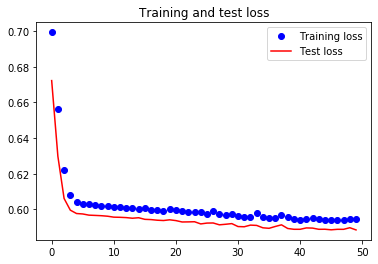

In [519]:
grafica_loss(autoencoder_deep, 50)

In [520]:
# Este es el modelo con el que obtenemos la representación latente
espectro_encoded = encoder.predict(espectros_test) 

# Esta es la salida del autoencoder, para comprobar si se parece a la entrada
espectro_decoded = autoencoder_deep.predict(espectros_test) 

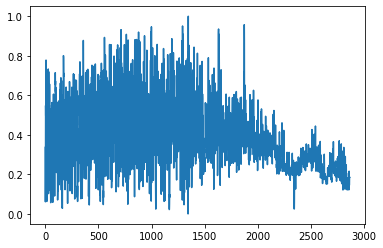

In [521]:
plt.plot(espectros_test[10]);

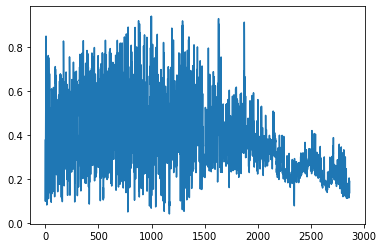

In [522]:
plt.plot(espectro_decoded[10]);

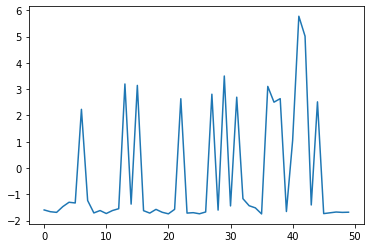

In [523]:
plt.plot(espectro_encoded[10]);

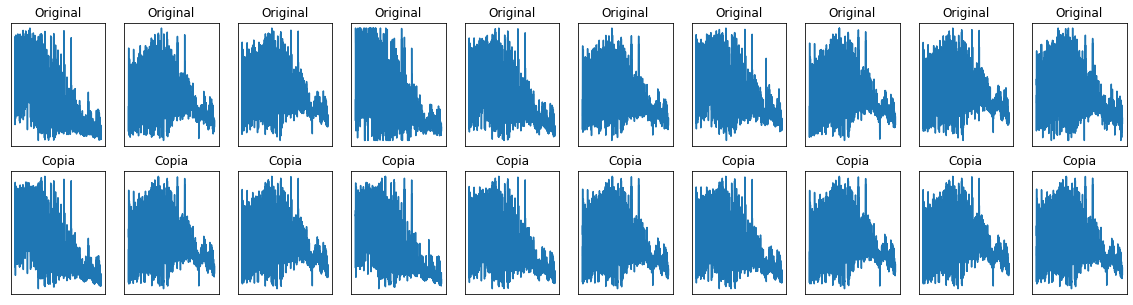

In [504]:
n = 10 
shift = 0
plt.figure(figsize=(20, 5))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.plot(espectros_test[i+shift])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("Original")

    # Reconstrucción
    ax = plt.subplot(2, n, i + 1 + n)
    plt.plot(espectro_decoded[i+shift])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("Copia")

Por tanto vamos a usar el modelo anterior sobre todos los espectros de que disponemos y recoger la representanción latente de los mismos.

In [505]:
espectros_latentes = encoder.predict(espectros)

## Cálculo del número óptimo de clusters

Antes de pasar las representaciones latentes obtenidas a un algoritmo de clustering, vamos a determinar el número óptimo de clusters. Hay varios métodos (ninguno es el más recomendado para todos los casos) y lo aconsejable será probarlos todos y ver si existe una cierta coincidencia.

Se usarán los siguientes métodos:

* Elbow method
* Silhouette method
* Gap statistics
* Calinsky Criterion
* BIC (Bayesian Information Criterion)

#### 1.- Elbow method

In [506]:
# Aquí guardaremos los resultados obtenidos en cada método
esquema = {"metodo", "k_optimo"}
k_resultados = pd.DataFrame(columns=esquema)

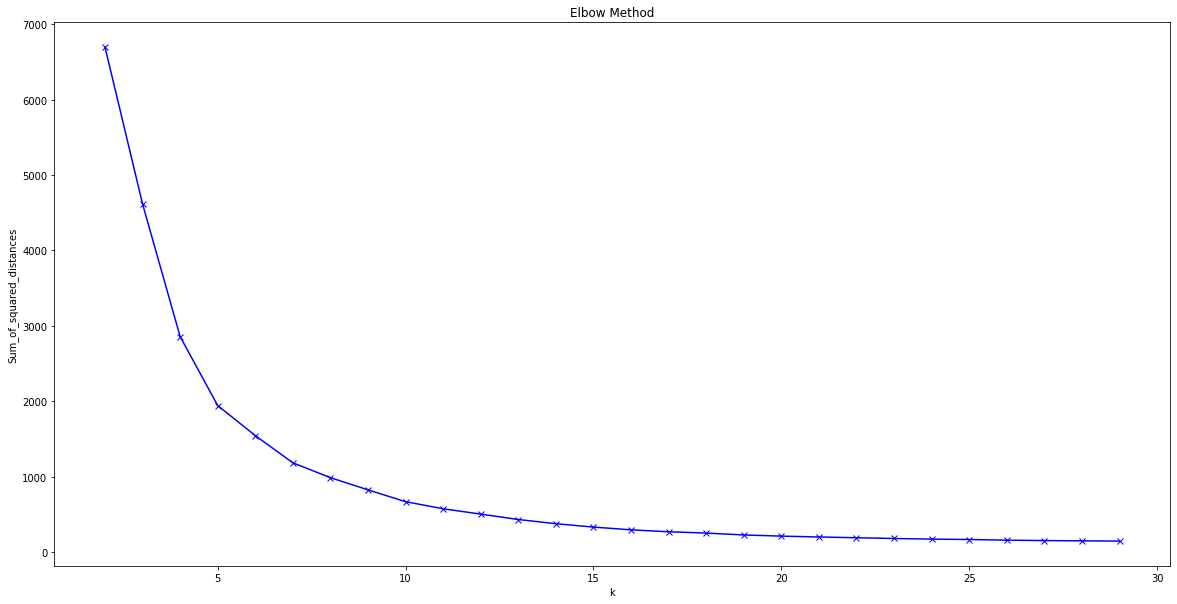

In [507]:
ssd = []
valores_k = range(2,30)
for k in valores_k:
    km = KMeans(n_clusters=k)
    km = km.fit(espectros_latentes)
    ssd.append(km.inertia_)
    
plt.figure(figsize=(20, 10));    
plt.plot(valores_k, ssd, 'bx-');
plt.xlabel('k');
plt.ylabel('Sum_of_squared_distances');
plt.title('Elbow Method');

El número resultante es 4

In [70]:
k_resultados.loc[0]=["Elbow method", 4]

#### 2.- Silhouette method

For n_clusters = 2 the average silhouette_score is : 0.5282776
For n_clusters = 3 the average silhouette_score is : 0.55572635
For n_clusters = 4 the average silhouette_score is : 0.5705484
For n_clusters = 5 the average silhouette_score is : 0.55342406
For n_clusters = 6 the average silhouette_score is : 0.54734063
For n_clusters = 7 the average silhouette_score is : 0.54105353
For n_clusters = 8 the average silhouette_score is : 0.5345348
For n_clusters = 9 the average silhouette_score is : 0.5534749
For n_clusters = 10 the average silhouette_score is : 0.55450875
For n_clusters = 11 the average silhouette_score is : 0.5556044
For n_clusters = 12 the average silhouette_score is : 0.55197066
For n_clusters = 13 the average silhouette_score is : 0.5499019
For n_clusters = 14 the average silhouette_score is : 0.54657435
For n_clusters = 15 the average silhouette_score is : 0.5428597
For n_clusters = 16 the average silhouette_score is : 0.5358451
For n_clusters = 17 the average silhouett

/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


For n_clusters = 22 the average silhouette_score is : 0.53300166


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


For n_clusters = 23 the average silhouette_score is : 0.52270395


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


For n_clusters = 24 the average silhouette_score is : 0.5362548


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


For n_clusters = 25 the average silhouette_score is : 0.5410583


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


For n_clusters = 26 the average silhouette_score is : 0.53509516


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


For n_clusters = 27 the average silhouette_score is : 0.53133416


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


For n_clusters = 28 the average silhouette_score is : 0.5378813


/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


For n_clusters = 29 the average silhouette_score is : 0.5371093


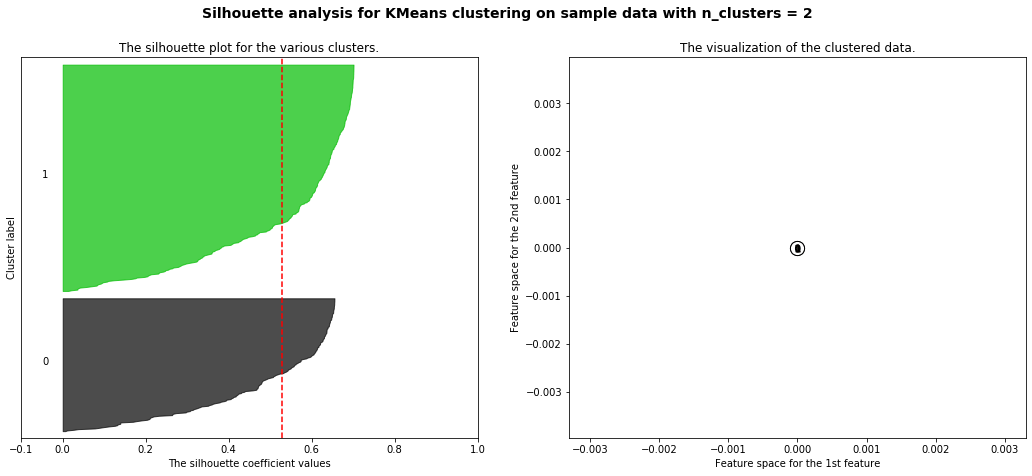

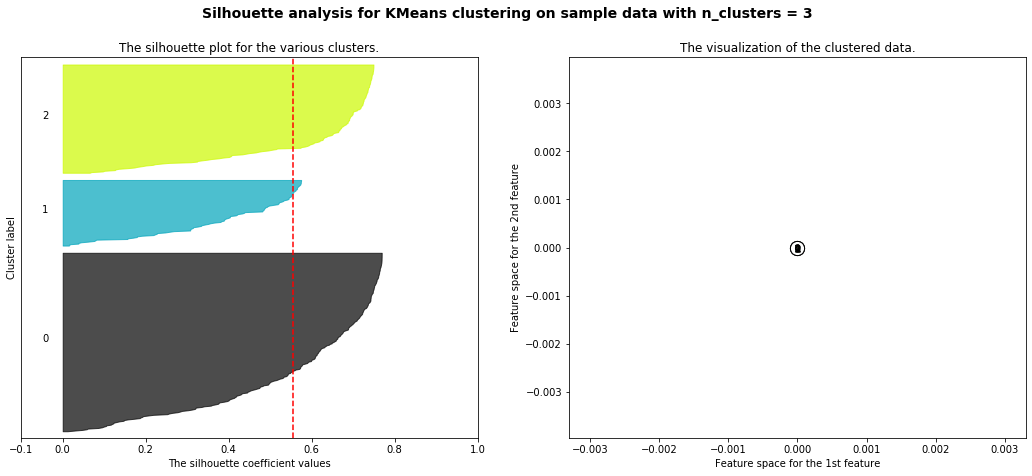

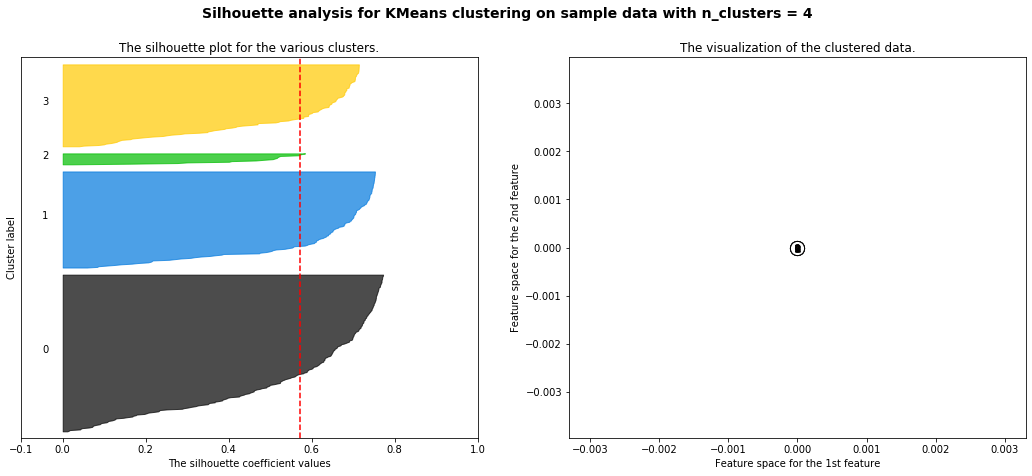

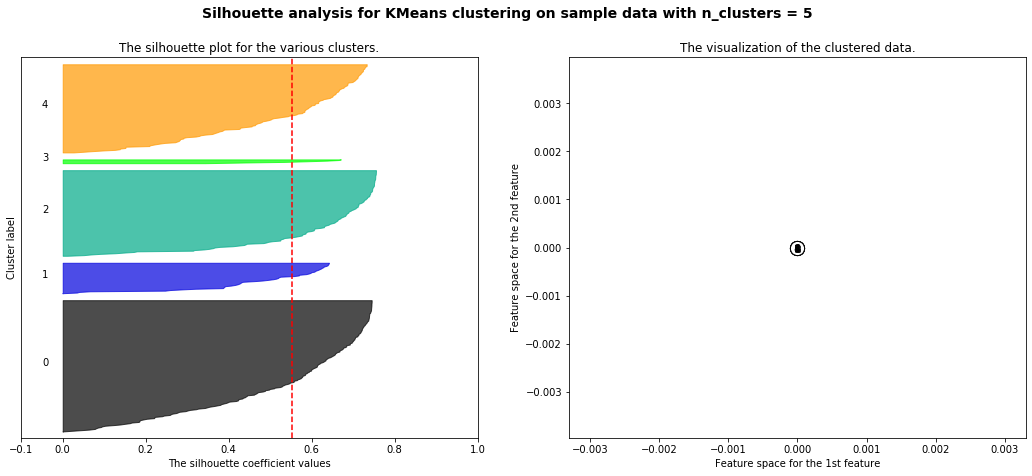

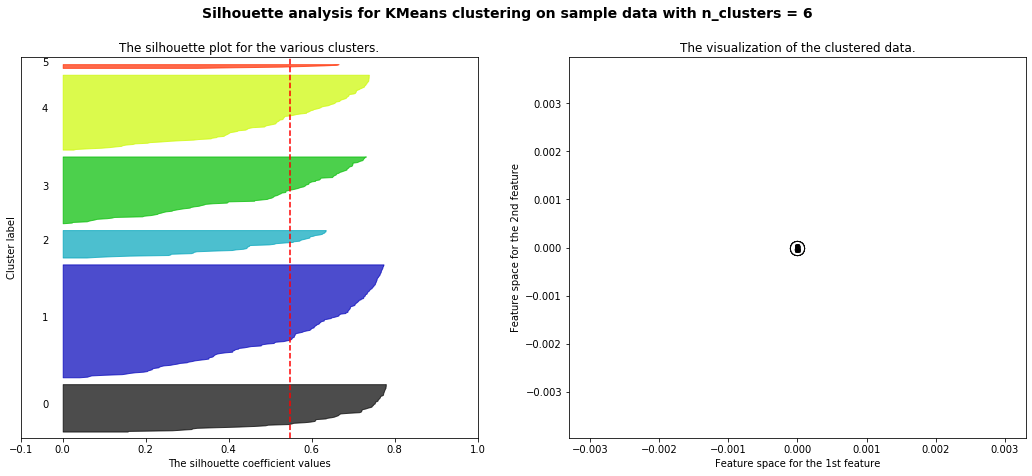

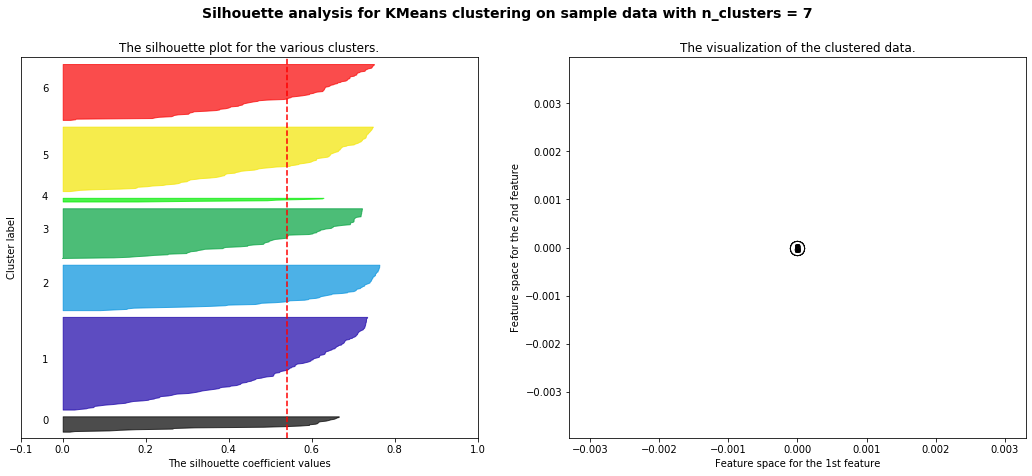

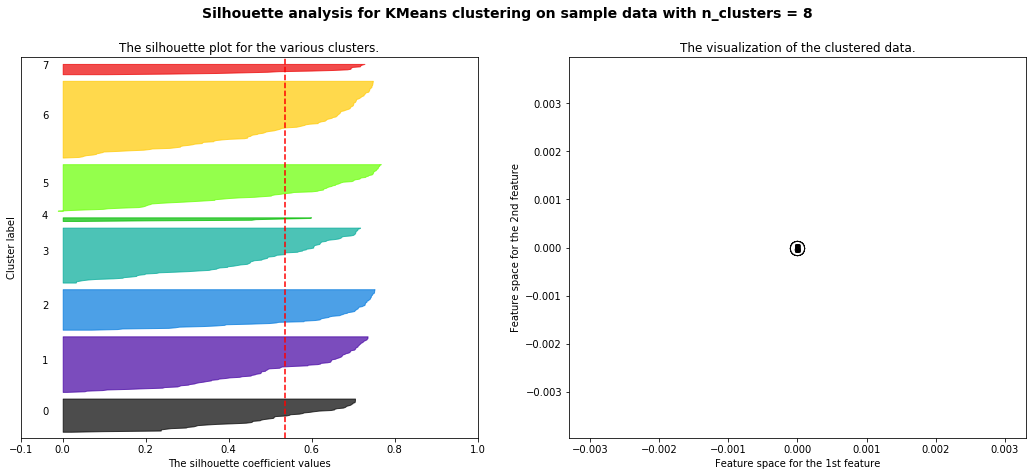

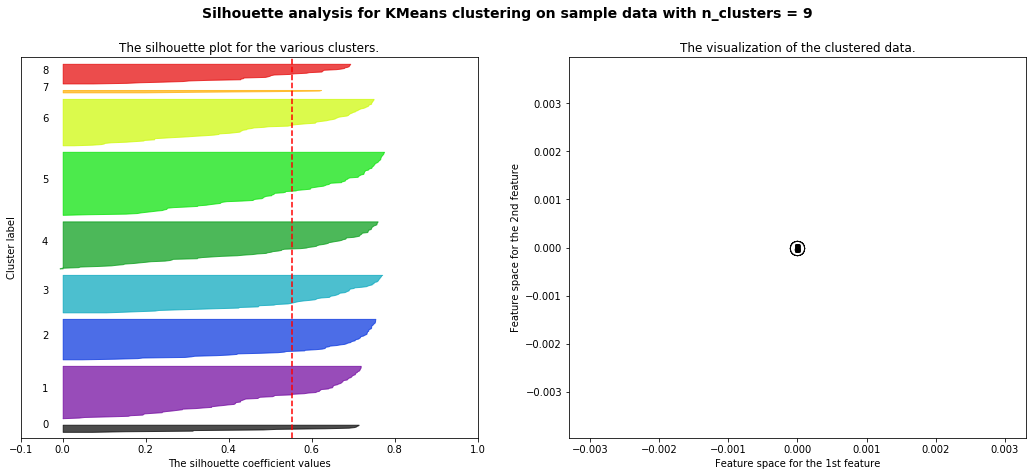

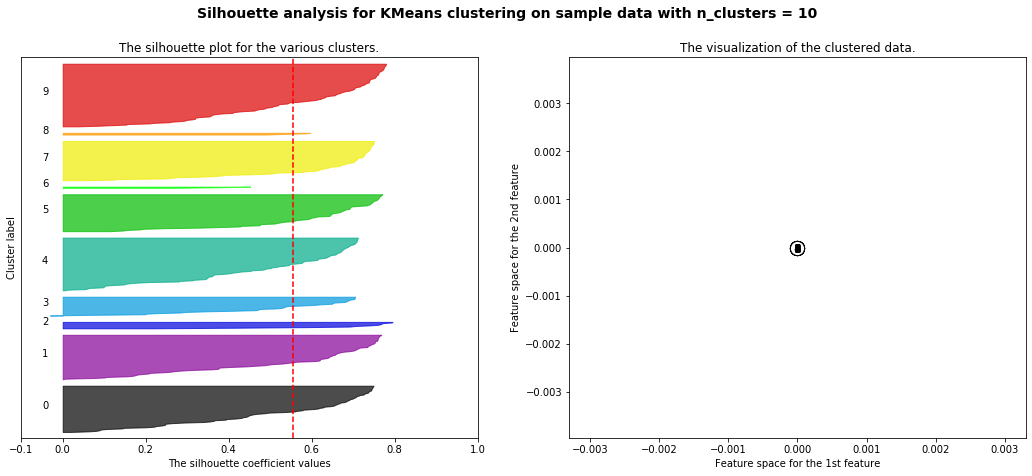

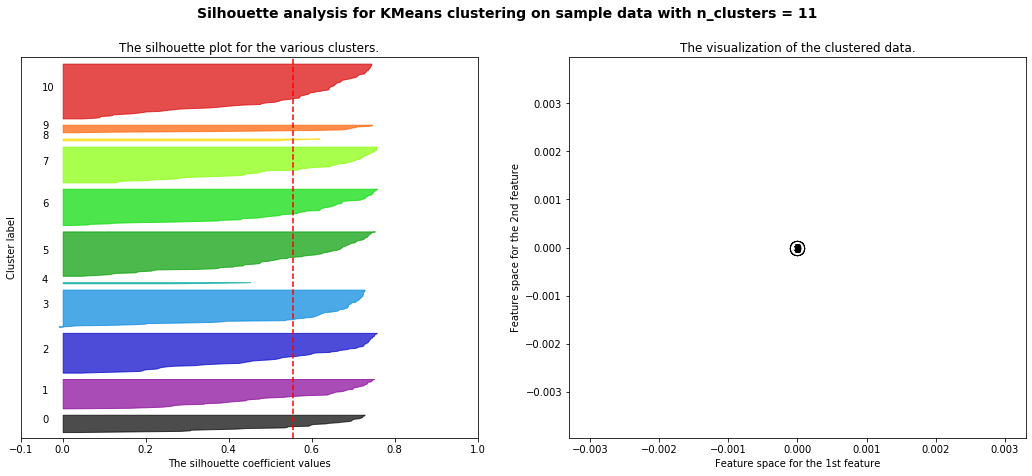

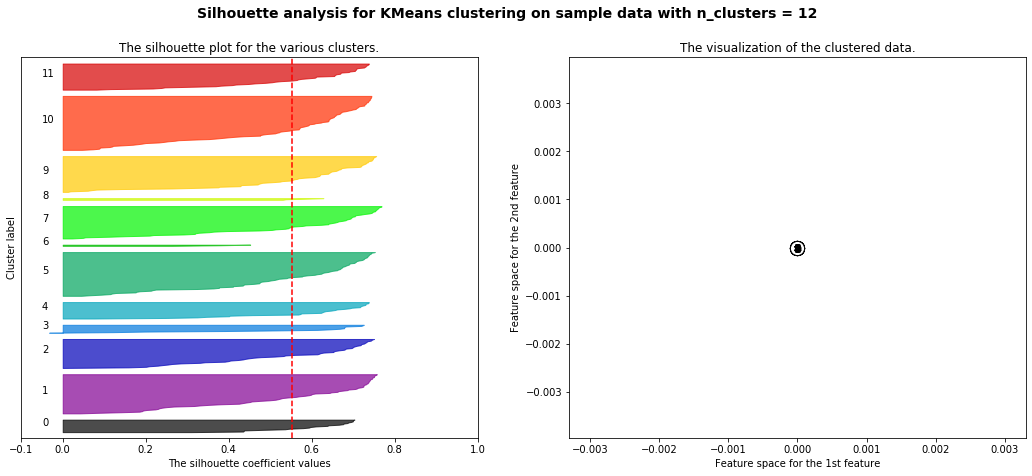

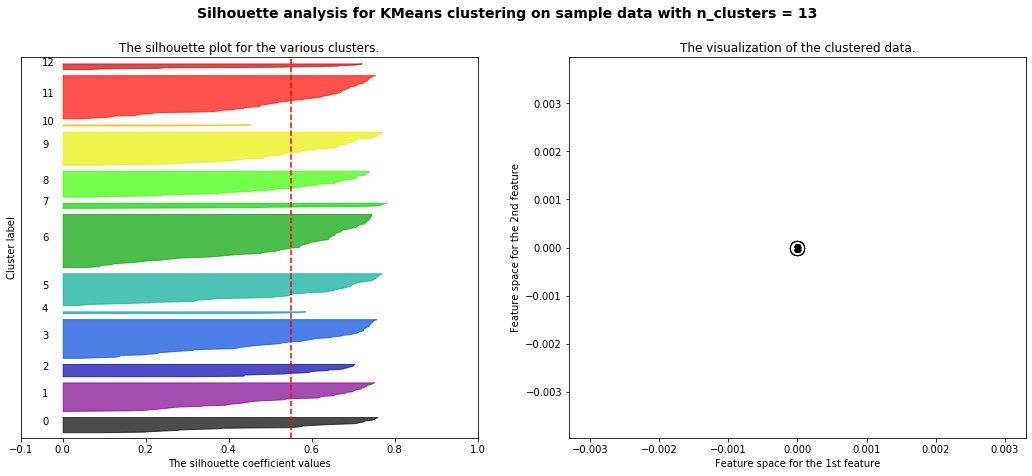

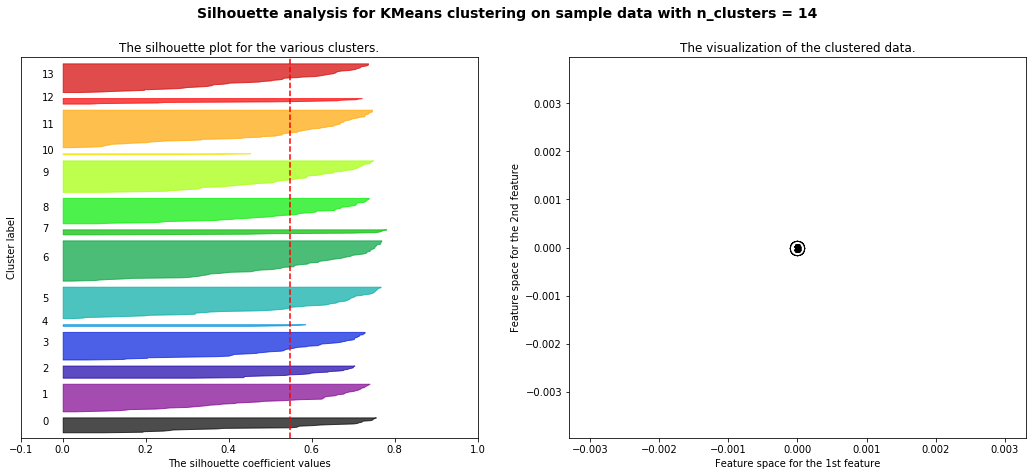

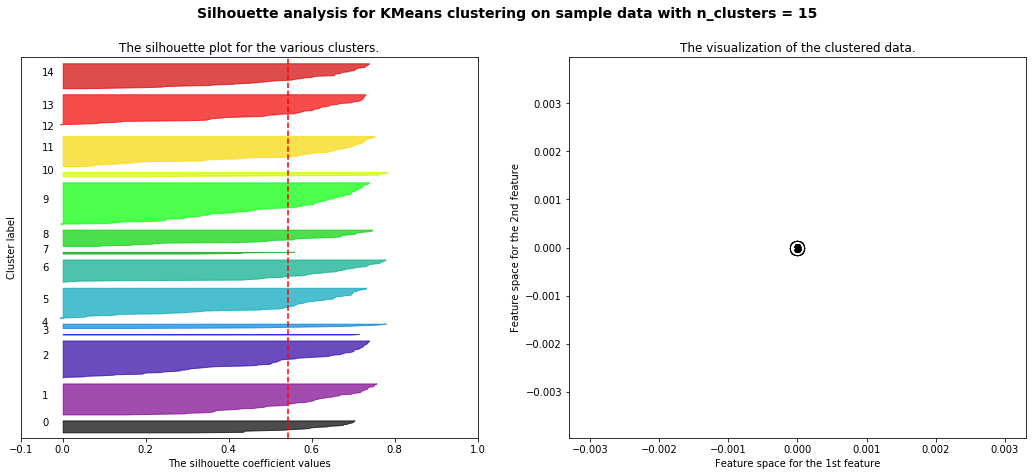

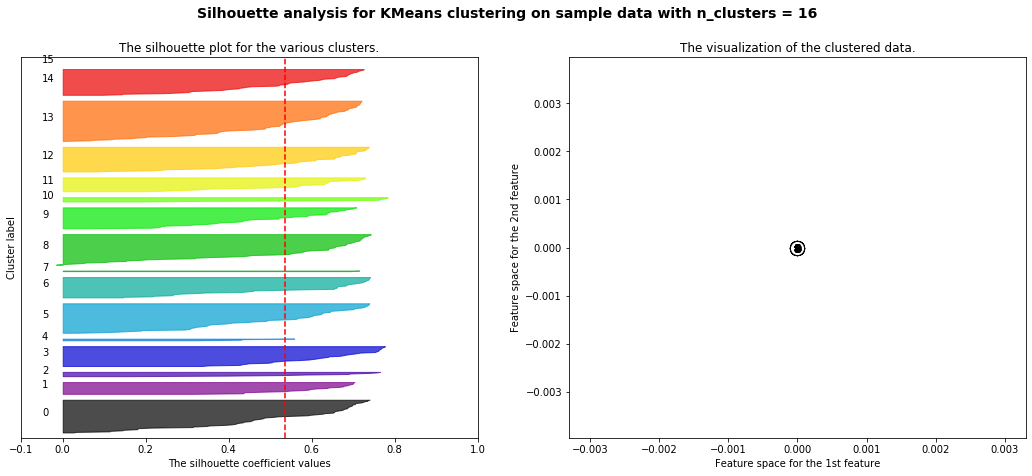

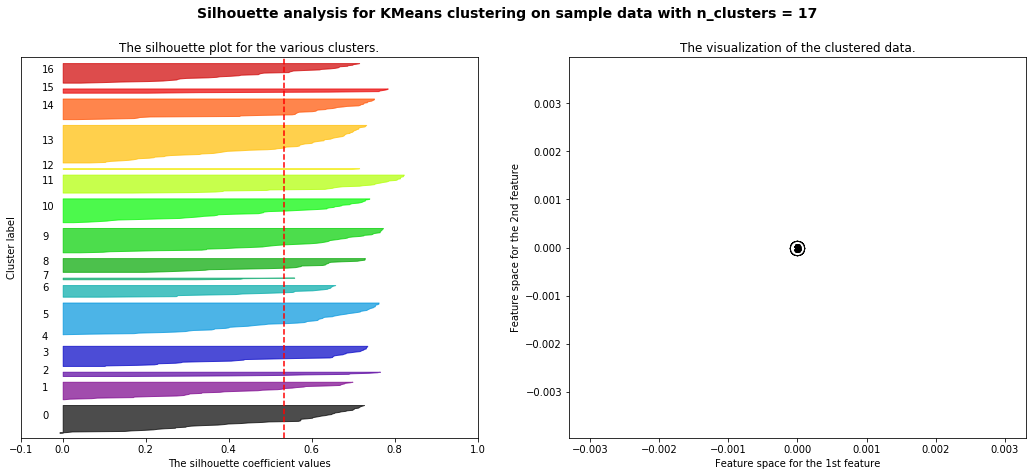

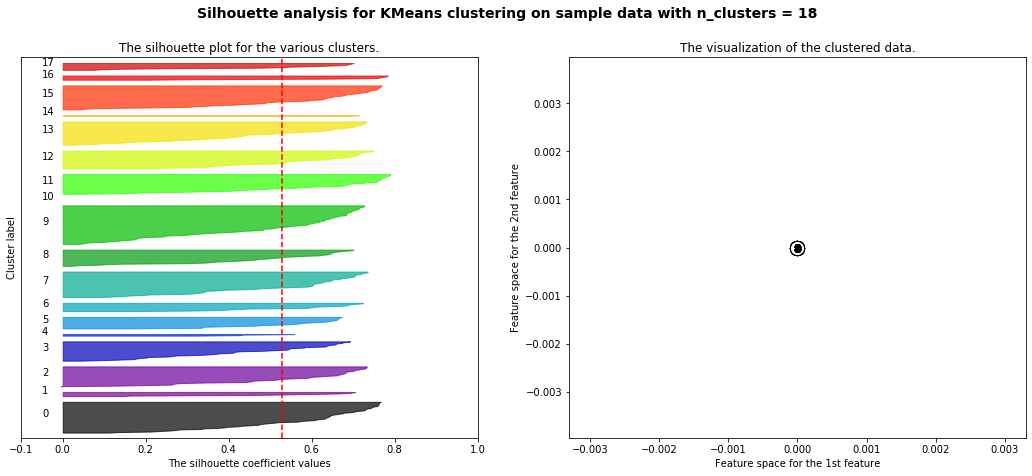

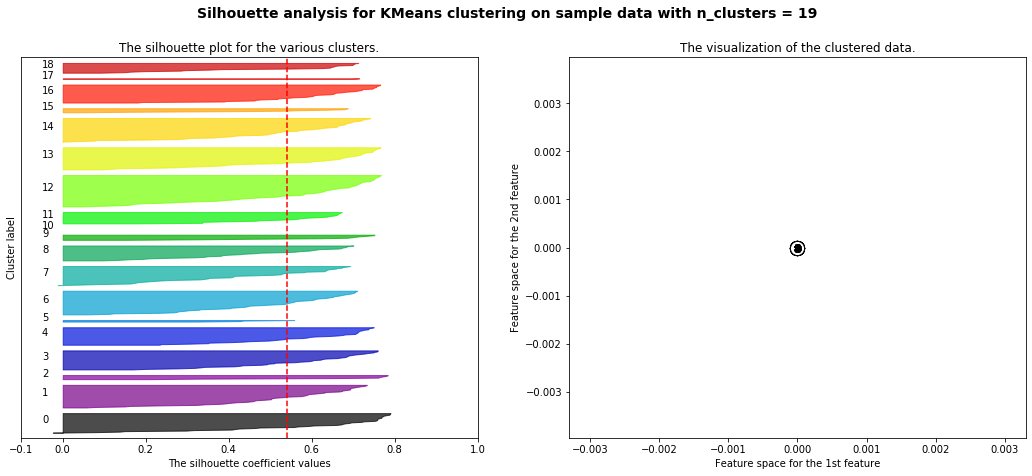

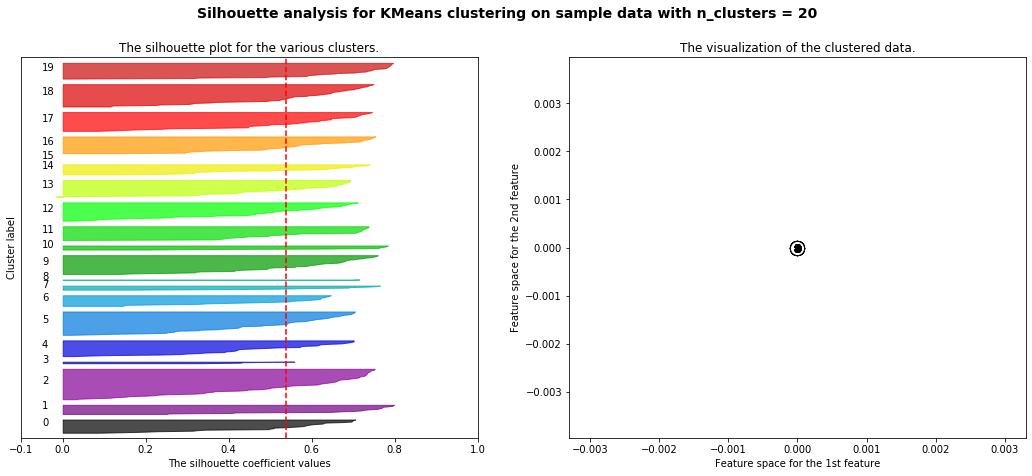

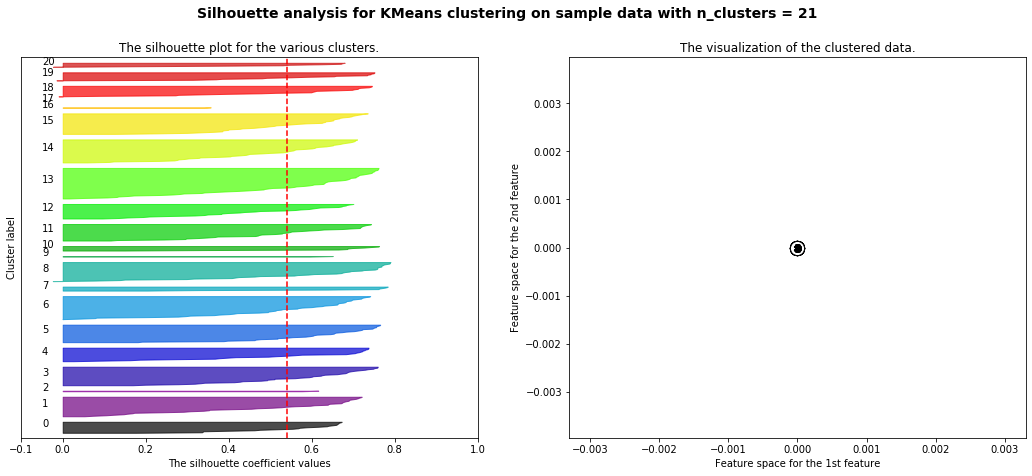

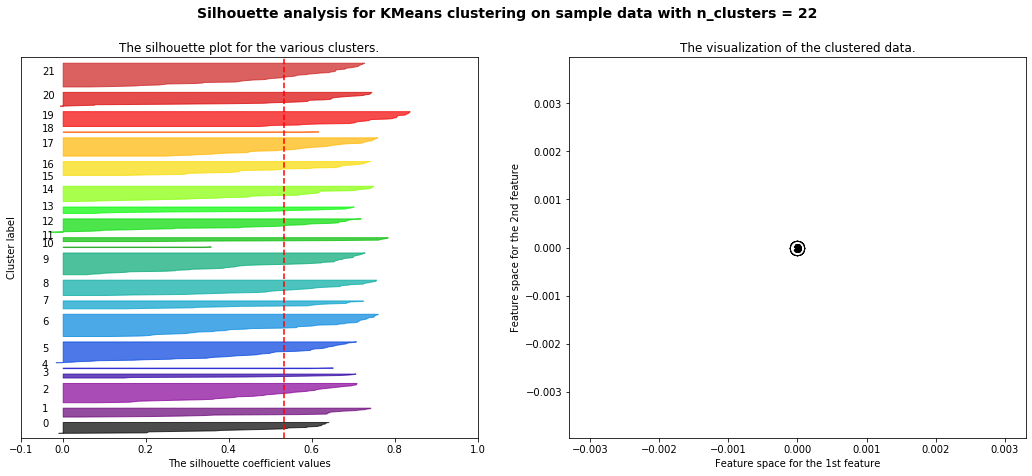

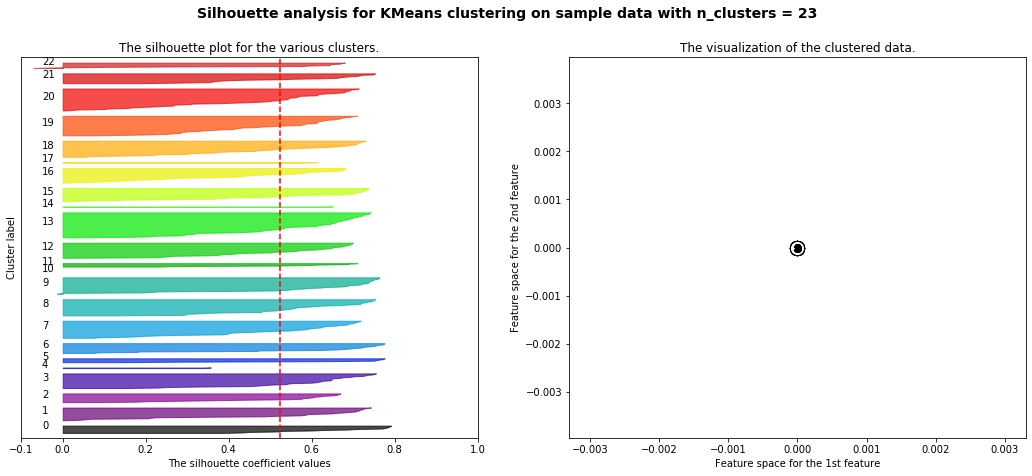

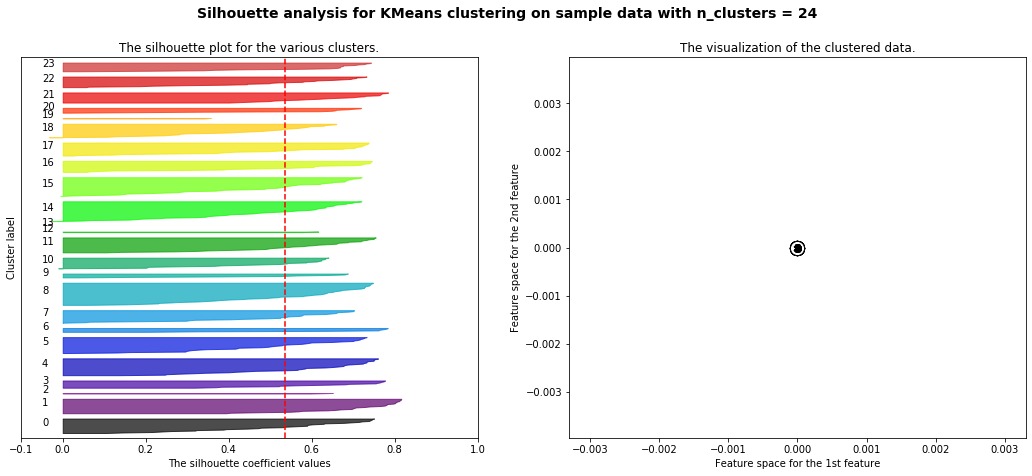

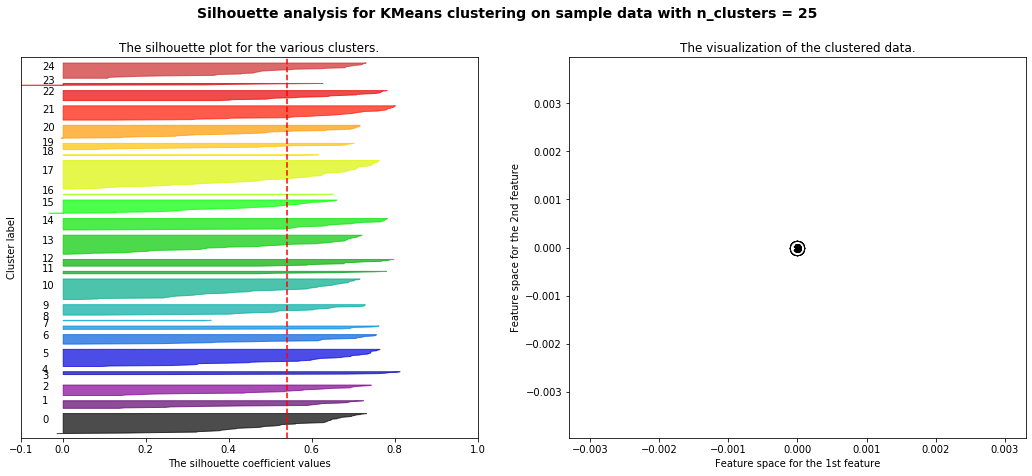

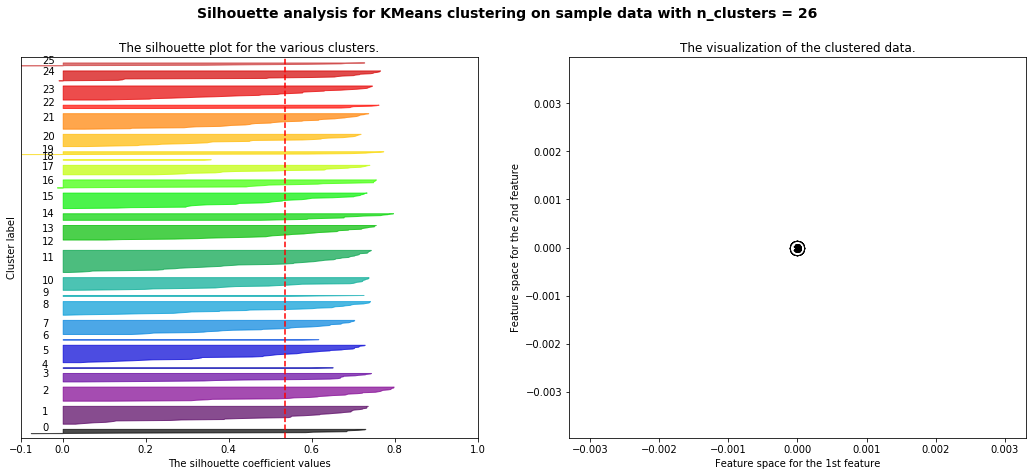

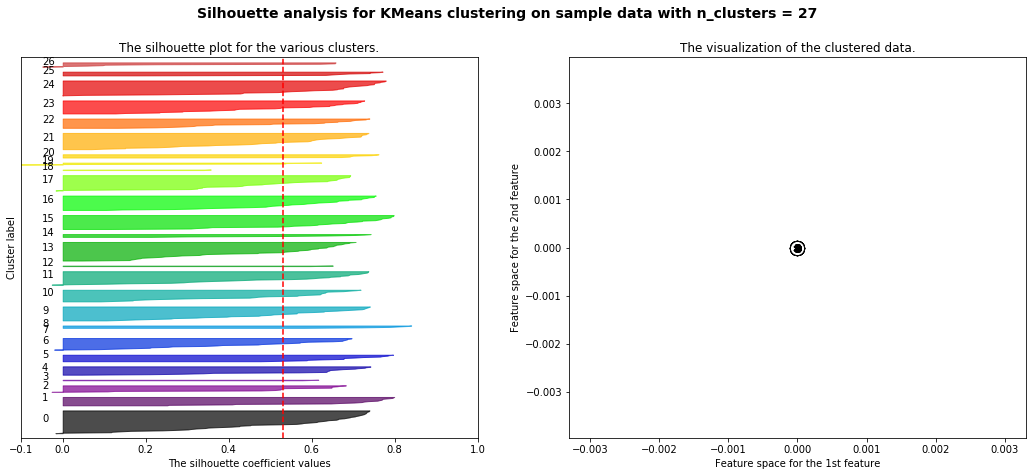

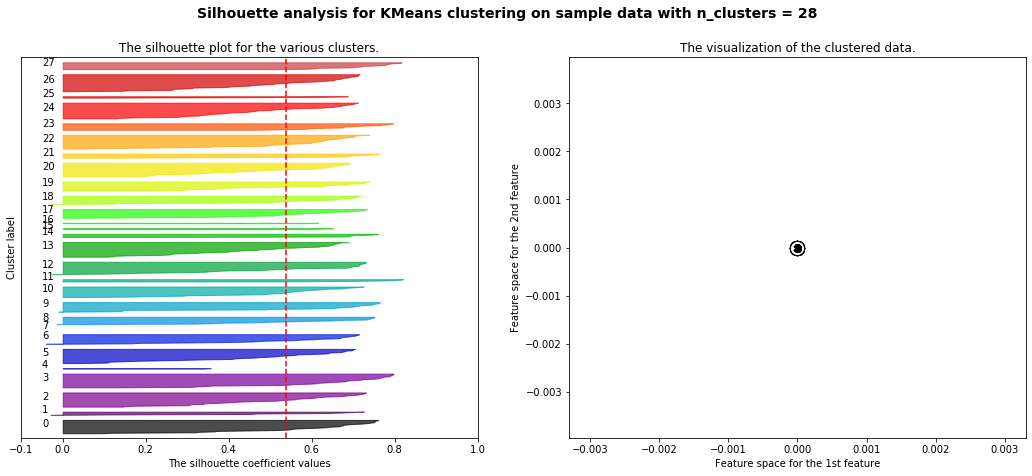

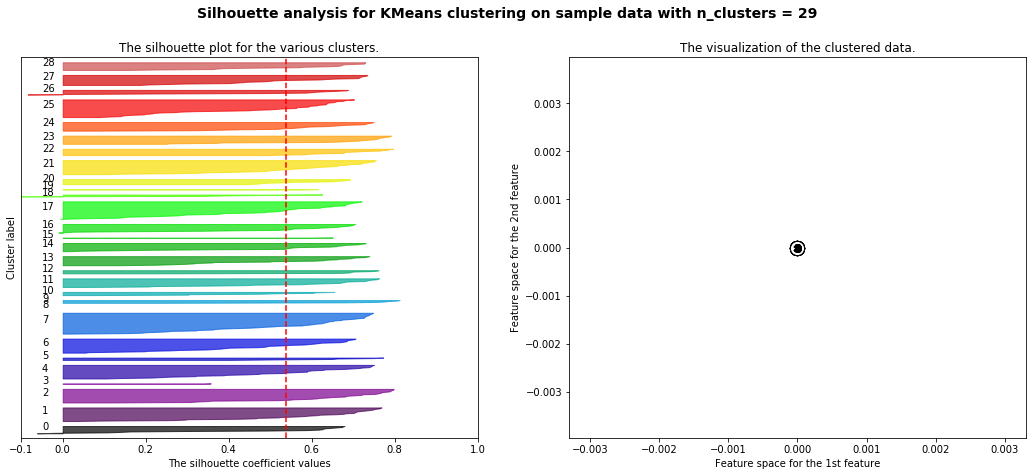

In [46]:
sil_history = []
for k in valores_k:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(espectros_latentes) + (k + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusterer.fit_predict(espectros_latentes)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(espectros_latentes, cluster_labels)
    sil_history.append((silhouette_avg,k))
    print("For n_clusters =", k,
          "the average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(espectros_latentes, cluster_labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(espectros_latentes[:, 0], espectros_latentes[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')


In [47]:
ind_optimo = np.argmax([x[0] for x in sil_history])

print ("Número óptimo de clusters: ", sil_history[ind_optimo][1])
print ("Con puntuación:", sil_history[ind_optimo][0])

Número óptimo de clusters:  4
Con puntuación: 0.5705484


Quitando el 2, el siguiente mejor es el de 4 clusters.

Otro método más sencillo y visual

In [44]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

n_clusters=np.arange(2, 30)
sils=[]
sils_err=[]
iterations=20
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        km=KMeans(n).fit(espectros_latentes) 
        labels=km.predict(espectros_latentes)
        sil=silhouette_score(espectros_latentes, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

Text(0, 0.5, 'Score')

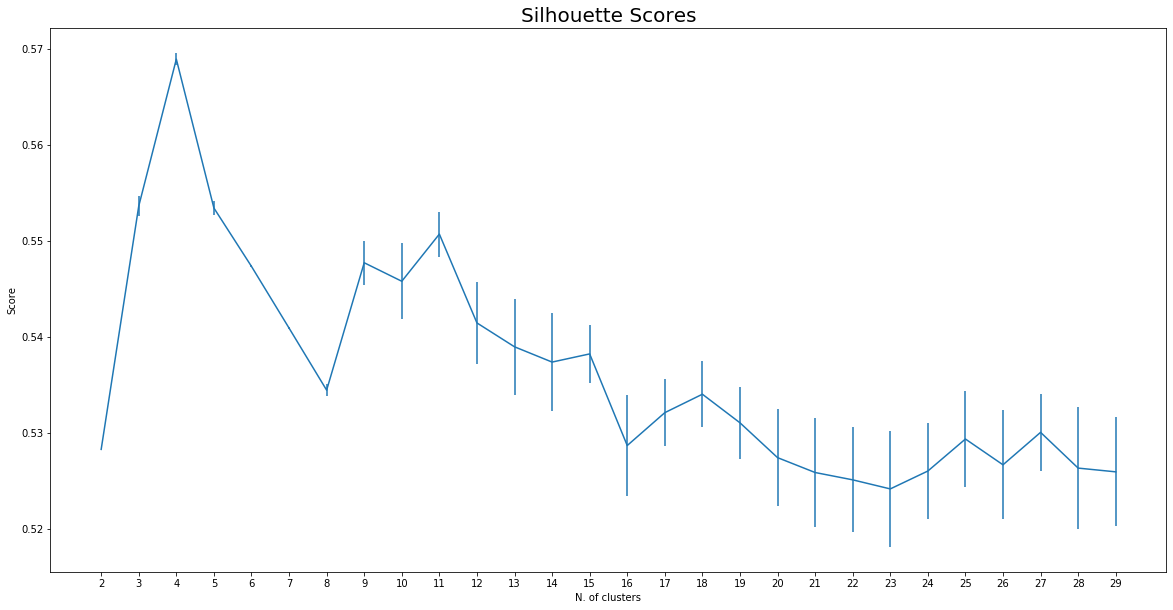

In [45]:
plt.figure(figsize=(20, 10)); 
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

Mismo resultado

In [71]:
k_resultados.loc[1]=["Silhouette method", 4]

#### 3.- Gap statistics

In [49]:
espectros_latentes.shape

(540, 50)

In [48]:
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal
    

In [50]:
k, gapdf = optimalK(espectros_latentes, nrefs=3, maxClusters=50)
print ('Optimal k is: ', k)

Optimal k is:  49


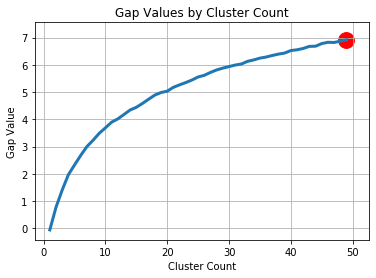

In [51]:
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

Lo que esto nos dice es que este método no logra determinar un número adecuado de clusters, aunque parece que la curva se empieza a estabilizar al tope.

In [72]:
k_resultados.loc[2]=["Gap statistics", 49]

#### 4.- Calinsky Criterion

In [53]:
cal_hist =[]
for k in range(2, 50):
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(espectros_latentes)
    labels = kmeans_model.labels_
    labels = kmeans_model.labels_
    cal_hist.append((k, calinski_harabasz_score(espectros_latentes, labels)))

In [54]:
ind_optimo = np.argmax([x[0] for x in cal_hist])

print ("Número óptimo de clusters: ", cal_hist[ind_optimo][0])
print ("Con puntuación:", cal_hist[ind_optimo][1])

Número óptimo de clusters:  49
Con puntuación: 14345.83342209895


La misma situación que con Gap statistics

In [73]:
k_resultados.loc[3]=["Calinsky Criterion", 49]

#### 5.- BIC

In [56]:
def compute_bic(kmeans,X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)], [centers[0][i]], 
             'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term

    return(BIC)


In [57]:
n_clusters=np.arange(2, 50)
# run 9 times kmeans and save each result in the KMeans object
km = [KMeans(n_clusters = i, init="k-means++").fit(espectros_latentes) for i in n_clusters]

# now run for each cluster the BIC computation
BIC = [compute_bic(kmeansi,espectros_latentes) for kmeansi in km]

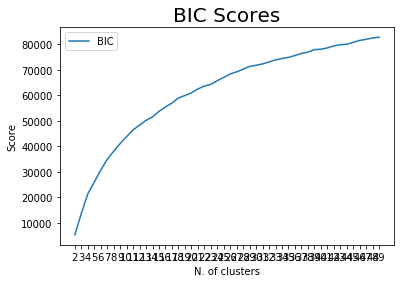

In [58]:
plt.errorbar(n_clusters,BIC, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()

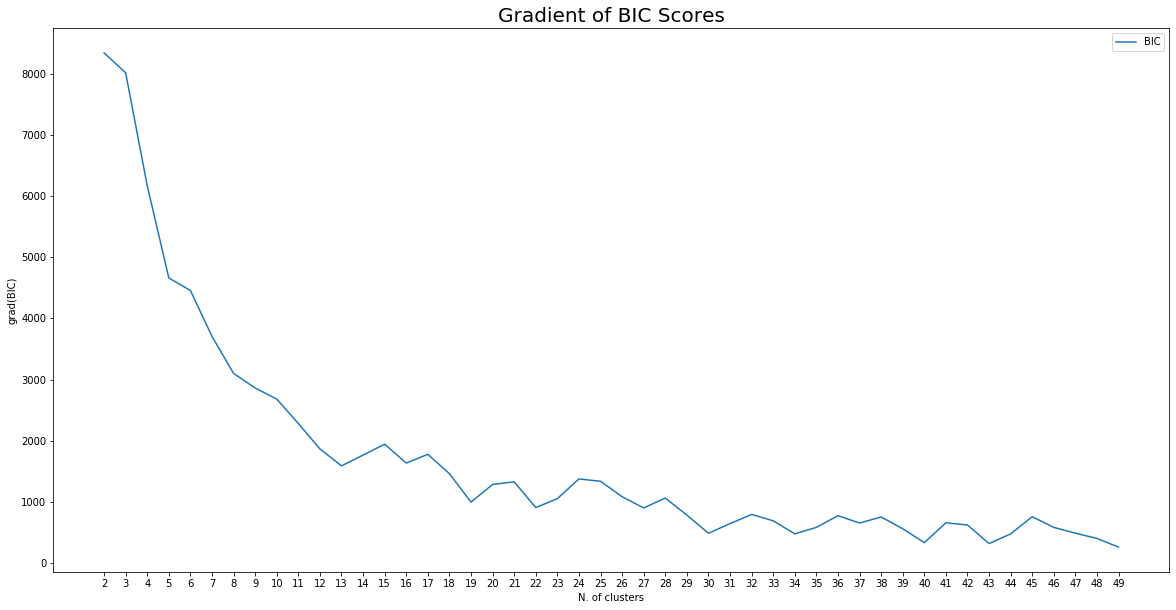

In [59]:
plt.figure(figsize=(20, 10)); 
plt.errorbar(n_clusters, np.gradient(BIC), label='BIC')
plt.title("Gradient of BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("grad(BIC)")
plt.legend()

Parece que, de nuevo, el resultado óptimo es 4

Cambiamos KMeans por Gaussian Mixture Model (GMM)

In [60]:
n_clusters=np.arange(2, 30)
bics=[]
iterations=20
for n in n_clusters:
    tmp_bic=[]
    for _ in range(iterations):
        gmm=GMM(n, n_init=2).fit(espectros_latentes) 
        tmp_bic.append(gmm.bic(espectros_latentes))
    val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
    bics.append(val)

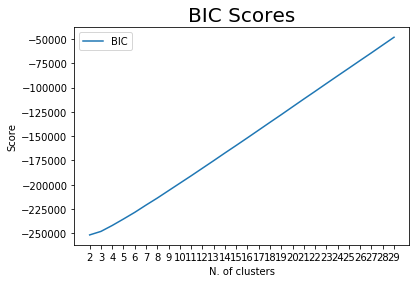

In [61]:
plt.plot(n_clusters,bics, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()

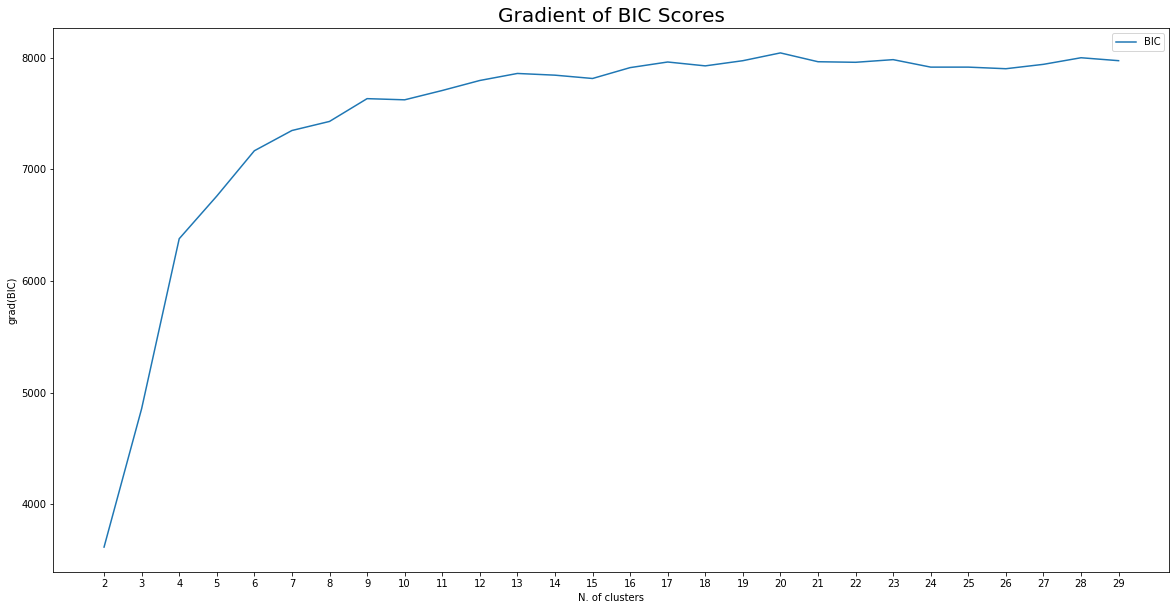

In [62]:
plt.figure(figsize=(20, 10)); 
plt.plot(n_clusters, np.gradient(bics), label='BIC');
plt.title("Gradient of BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("grad(BIC)")
plt.legend()

Aquí también resulta 4

In [74]:
k_resultados.loc[4]=["BIC", 4]

In [75]:
k_resultados

,k_optimo,metodo
0,Elbow method,4
1,Silhouette method,4
2,Gap statistics,49
3,Calinsky Criterion,49
4,BIC,4


Por tanto, 3 de los 5 métodos coinciden en que el número óptimo de clusters es 4 (lo que no resulta conforme a lo esperado; ASK contaba con 28 clusters.

Vamos ahora a ejecutar entonces el clustering con 4 clusters y analicemos los resultados. Lo cierto es que he disminuido el número de variables del espacio latente a 50, precisamente con la intención de que ese sea el número de clusters (o un poco menos).